In [1]:
# Importing necessary libraries for image processing and visualization
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.exposure import histogram

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/'
date = '2023_11_15'

image_files = [folder_path + date + '_10x_1.0x_pLPT20&41_Ti_Pos{}.ome.tif'.format(i) for i in range(4)]
mask_files = [folder_path + 'mask_' + date + '_10x_1.0x_pLPT20&41_Ti_Pos{}.ome.tif'.format(i) for i in range(4)]
print(image_files)
print(mask_files)

#images = np.array([imread(file, as_gray=True) for file in image_files])
images = np.array([imread(file) for file in image_files])
masks = np.array([imread(file) for file in mask_files])
print(images.shape)
print(images[0].shape)
print(masks.shape)

Mounted at /content/drive
['/content/drive/My Drive/cell_dataset/2023_11_15_Ti/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos0.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos1.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos2.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos3.ome.tif']
['/content/drive/My Drive/cell_dataset/2023_11_15_Ti/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos0.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos1.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos2.ome.tif', '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos3.ome.tif']
(4, 216, 1200, 1200, 3)
(216, 1200, 1200, 3)
(4, 216, 1200, 1200)


In [3]:
images = images / 255.0

In [4]:
train_images = images[:3]
train_masks = masks[:3]
val_images = images[3:]
val_masks = masks[3:]
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(3, 216, 1200, 1200, 3)
(3, 216, 1200, 1200)
(1, 216, 1200, 1200, 3)
(1, 216, 1200, 1200)


In [5]:
# Combine the first and second dimensions and add a channel dimension to the masks.
train_images = train_images.reshape(-1, 1200, 1200, 3)
train_masks = train_masks.reshape(-1, 1200, 1200, 1)
val_images = val_images.reshape(-1, 1200, 1200, 3)
val_masks = val_masks.reshape(-1, 1200, 1200, 1)

print(train_images.shape)  # (432, 1200, 1200, 1)
print(train_masks.shape)   # (432, 1200, 1200, 1)
print(val_images.shape)    # (432, 1200, 1200, 1)
print(val_masks.shape)     # (432, 1200, 1200, 1)

(648, 1200, 1200, 3)
(648, 1200, 1200, 1)
(216, 1200, 1200, 3)
(216, 1200, 1200, 1)


In [6]:
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

target_size = (256, 256)
train_images = resize_images(train_images, target_size)
train_masks = resize_images(train_masks, target_size)
val_images = resize_images(val_images, target_size)
val_masks = resize_images(val_masks, target_size)

# Normalize the mask values to 0 and 1.
def binarize_masks(masks):
    masks = np.where(masks > 0, 1, 0)
    return masks

train_masks = binarize_masks(train_masks)
val_masks = binarize_masks(val_masks)

In [7]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(648, 256, 256, 3)
(648, 256, 256, 1)
(216, 256, 256, 3)
(216, 256, 256, 1)


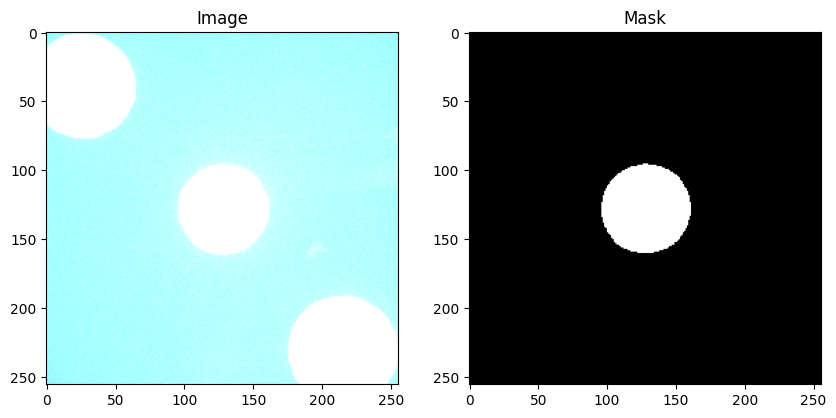

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images[100], cmap='gray')
axes[0].set_title('Image')
axes[1].imshow(train_masks[100], cmap='gray')
axes[1].set_title('Mask')
plt.show()

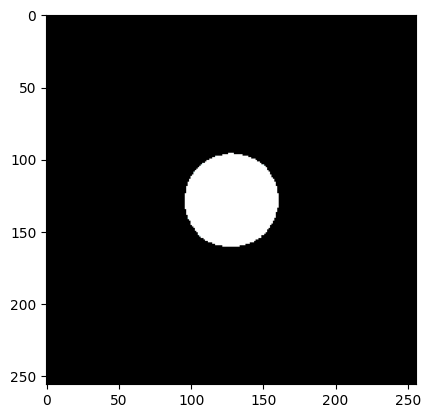

In [9]:
masked_image = np.where(train_masks[100], train_images[100], 0)
plt.imshow(masked_image, cmap='gray')

In [ ]:
# model = Sequential([
#     Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 1), padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2D(1, (1, 1), activation='sigmoid', padding='same')
# ])

# model = Sequential([
#     Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 1), padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same'),
#     Conv2D(1, (1, 1), activation='sigmoid', padding='same')
# ])

# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# history = model.fit(datagen.flow(train_images, train_masks, batch_size=8),
#                     validation_data=(val_images, val_masks),
#                     epochs=20)


In [10]:
# Input layer
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Use the pre-trained VGG16 as the base
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# vgg16.summary()
block5_conv3 = vgg16.get_layer('block5_conv3').output
block4_conv3 = vgg16.get_layer('block4_conv3').output
block3_conv3 = vgg16.get_layer('block3_conv3').output

# Transposed convolution layers for upsampling
x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)
x = concatenate([x, block4_conv3])
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = concatenate([x, block3_conv3])
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# The final convolution layer to produce the output of the same size as the input
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                             

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(datagen.flow(train_images, train_masks, batch_size=8),
                    validation_data=(val_images, val_masks),
                    epochs=10)

Epoch 1/10
81/81 [==============================] - 76s 651ms/step - loss: 0.7268 - accuracy: 0.9384 - val_loss: 0.0638 - val_accuracy: 0.9486
Epoch 2/10
81/81 [==============================] - 31s 385ms/step - loss: 0.0548 - accuracy: 0.9780 - val_loss: 0.0523 - val_accuracy: 0.9827
Epoch 3/10
81/81 [==============================] - 32s 388ms/step - loss: 0.0472 - accuracy: 0.9831 - val_loss: 0.0448 - val_accuracy: 0.9834
Epoch 4/10
81/81 [==============================] - 32s 391ms/step - loss: 0.0417 - accuracy: 0.9836 - val_loss: 0.0378 - val_accuracy: 0.9848
Epoch 5/10
81/81 [==============================] - 32s 394ms/step - loss: 0.0373 - accuracy: 0.9848 - val_loss: 0.0373 - val_accuracy: 0.9834
Epoch 6/10
81/81 [==============================] - 32s 397ms/step - loss: 0.0351 - accuracy: 0.9856 - val_loss: 0.0329 - val_accuracy: 0.9849
Epoch 7/10
81/81 [==============================] - 32s 398ms/step - loss: 0.0339 - accuracy: 0.9862 - val_loss: 0.0362 - val_accuracy: 0.9830

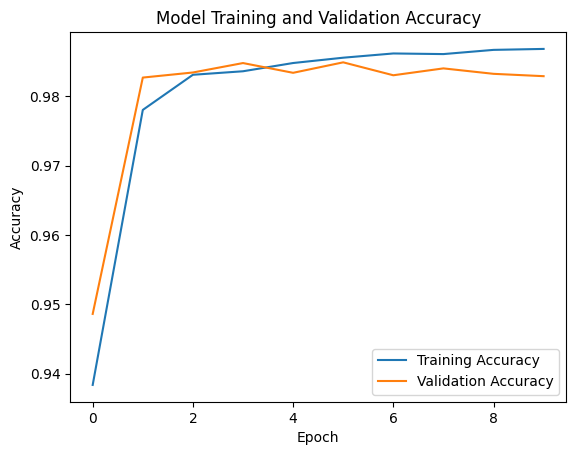

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()